In [ ]:
# Google Colab
from google.colab import drive
%tensorflow_version 2.x

# System
import sys
import os

%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf

print("Python version :",sys.version)
print("TensorFlow version :",tf.version.VERSION)

devices = tf.config.list_physical_devices()
print(f"\n>> Available devices:\n {devices}")
# beginning /physical_device  is subtracted
GPU, CPU, BESTDEV = None, None, None
for dev in devices:
    if dev.device_type == 'GPU':
            tokens = dev.name.split(':')[-2:]
            name = ':'.join(tokens)
            GPU = '/device:' + name
            print(f"GPU device found: '{GPU}'")
            BESTDEV = GPU
    elif dev.device_type == 'CPU':
            name = dev.name
            tokens = dev.name.split(':')[-2:]
            name = ':'.join(tokens)
            CPU = '/device:' + name
            print(f"CPU device found: '{CPU}'")
if not GPU:
    print("GPU device NOT found")
    BESTDEV = CPU
print(f"Best device is: '{BESTDEV}'")


from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Embedding,GRU,MaxPooling1D,GlobalMaxPooling1D,BatchNormalization

from sklearn.model_selection import train_test_split

from sklearn import metrics

import matplotlib.pyplot as plt
from matplotlib import cm

import itertools

#mount Google drive
print("Google drive :")
drive.mount("/content/drive",force_remount=True)
PATH_WORK = "/content/drive/MyDrive/Rakuten"

#go to working directory
os.chdir(PATH_WORK)
print("content of CWD :",os.listdir())

data_train = pd.read_csv('X_train_rakuten_afterEDA_preprocessing.csv',index_col=0)
data_train = data_train.reset_index(drop=False)
data_train['nom_img'] = r"/tmp/images/cropped_image_train/" + data_train['nom_img']
data_train.shape

Python version : 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
TensorFlow version : 2.6.0

>> Available devices:
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CPU device found: '/device:CPU:0'
GPU device found: '/device:GPU:0'
Best device is: '/device:GPU:0'
Google drive :
Mounted at /content/drive
content of CWD : ['X_train_rakuten_afterEDA_preprocessing.csv', 'cropped_image_train.zip', 'model.png', 'Rakuten_multimodal_Xception_embedding-GRU.h5']


(84613, 6)

In [ ]:
#display columns including product images (nom_img)
data_train.head()



,designation_orig,nom_img,lang_designation,designation,prdtypecode,designation_token_final
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,/tmp/images/cropped_image_train/image_12635970...,de,olivia: notebook personnalise / pages / punks...,10,"['notebook', 'page', 'design']"
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,/tmp/images/cropped_image_train/image_10081412...,fr,journal des art (le) n° du // art et son ma...,2280,"['journal', 'art', 'art', 'marche', 'salon', '..."
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,/tmp/images/cropped_image_train/image_93877797...,fr,grand stylet ergonomique bleu gamepad nintendo...,50,"['stylet', 'ergonomique', 'gamepad', 'nintendo..."
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,/tmp/images/cropped_image_train/image_45704749...,fr,peluche donald europe disneyland (marionn...,1280,"['peluche', 'donald', 'europe', 'disneyland', ..."
4,La Guerre Des Tuques Luc a des idées de grande...,/tmp/images/cropped_image_train/image_10777577...,fr,la guerre des tuques luc a des idees de grande...,2705,"['guerre', 'luc', 'idees', 'grandeur', 'vouloi..."


In [ ]:
%%bash

# Images source and destination
SRC="/content/drive/MyDrive/Rakuten/cropped_image_train.zip"
DEST="/tmp/images"


# Check it has not been done
if [ -d "$DEST" ]; then
    echo "Images already unzipped"
else
    # Create directory and unzip all set of images
    mkdir -p "$DEST"
    unzip -q "$SRC" -d "$DEST"
    echo "Images unzipped"
fi

Images already unzipped


In [ ]:
#delete rows where images are smaller than 2k equal to noise rather than information
from pathlib import Path

list_products_to_be_deleted_due_to_too_small_image = []
nbr_to_be_deleted = 0
for i in range(len(data_train)):
    fname = data_train['nom_img'].iloc[i]
    file_size =Path(fname).stat().st_size
    if (file_size < 2048):
        print("The file {0} has a too small size of {1} bytes ".format(fname,file_size))
        list_products_to_be_deleted_due_to_too_small_image.append(i)
        nbr_to_be_deleted += 1

#rows deletion
print("number of deleted rows due to image size smaller than 2K :",nbr_to_be_deleted)
print("shape before cleaning :",data_train.shape)
data_train = data_train.drop(list_products_to_be_deleted_due_to_too_small_image)
print("new shape of dataset after preprocessing : ", data_train.shape)

The file /tmp/images/cropped_image_train/image_332521213_product_46540267.jpg has a too small size of 1597 bytes 
The file /tmp/images/cropped_image_train/image_1289984514_product_4090784667.jpg has a too small size of 0 bytes 
The file /tmp/images/cropped_image_train/image_1216298756_product_3479934811.jpg has a too small size of 0 bytes 
The file /tmp/images/cropped_image_train/image_1026005405_product_558486639.jpg has a too small size of 0 bytes 
The file /tmp/images/cropped_image_train/image_1252146802_product_3845529844.jpg has a too small size of 0 bytes 
The file /tmp/images/cropped_image_train/image_1026005681_product_558486488.jpg has a too small size of 0 bytes 
The file /tmp/images/cropped_image_train/image_1166709808_product_2823853943.jpg has a too small size of 0 bytes 
The file /tmp/images/cropped_image_train/image_1303170478_product_4157448609.jpg has a too small size of 0 bytes 
The file /tmp/images/cropped_image_train/image_1283323476_product_4061150498.jpg has a too

In [ ]:
#cell specific for text preprocessing subpart 
# column designation_token_final is the result of preprocessing text cleaning (stopwords and so on) under tokens form
# so, we transform it again into text string in designation_str_tokens that is now the features data column
# to prepare the association between each word and a integer number (index in dictionary of full vocabulary describing products)
import re
data_train['designation_str_tokens'] = ""
for i in range(len(data_train)):
    data_train['designation_str_tokens'].iloc[i] += "".join(data_train['designation_token_final'].iloc[i]) 

data_train['designation_str_tokens'] = data_train['designation_str_tokens'].map(lambda x: re.sub(r',', '', x))
data_train['designation_str_tokens'] = data_train['designation_str_tokens'].map(lambda x: re.sub(r"'", '', x))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
#training and validation set , not yet test set 
target = data_train.prdtypecode
data_train = data_train.drop(['designation_orig','lang_designation','designation','designation_token_final','prdtypecode'],axis=1)

#Divide randomly data into training and validation set
#maintaining proportion of classes equal (stratify option)
X_train, X_test, y_train, y_test = train_test_split(data_train,target, test_size=0.2, random_state=42)

df_train = pd.concat([X_train,y_train],axis=1)
df_train = df_train.reset_index(drop=True)
df_test = pd.concat([X_test,y_test],axis=1)
df_test = df_test.reset_index(drop=True)

name_class = ['editions','magazines',"equipement_playstation","jouets_enfant","livres","fournitures_scolaires","materiel_jardin","mobilier_interieur","jeux_enfants","literie","livres_par_lot","figurine","materiel_piscine","univers_de_fiction","equipements_telecommandes","materiel_jeux_video","jeux_de_cartes_collection","decoration","jeux_video","console_de_jeu","materiel_bebe","peche_lampe_plein_air","materiel_animaux_compagnie","jeux_sur_PC","accessoires_outil","articles_nourriture","vetements_nouveau-né_et_billard_flechettes"] 
list_class = [10, 2280 ,  50 ,1280 ,2705, 2522, 2582, 1560, 1281, 1920, 2403, 1140, 2583, 1180, 1300 ,2462, 1160, 2060 , 40,   60 ,1320 ,1302 ,2220 ,2905, 2585, 1940 ,1301]       
list_class_onehot = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]

# df_train and df_test will be used to build the batchs !!!!!!
df_train['class_onehot']= 0
for i in range(len(df_train)):
    index = list_class.index(df_train['prdtypecode'].iloc[i])
    df_train['class_onehot'].iloc[i] = list_class_onehot[index]

df_test['class_onehot']= 0
for i in range(len(df_test)):
    index = list_class.index(df_test['prdtypecode'].iloc[i])
    df_test['class_onehot'].iloc[i] = list_class_onehot[index]

display(df_train.head(50))

print("\ndimension training set :",df_train.shape)
print("dimension test set :",df_test.shape)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,nom_img,designation_str_tokens,prdtypecode,class_onehot
0,/tmp/images/cropped_image_train/image_90058562...,[taggl jeu carte taggl faire joueur repartir j...,1281,8
1,/tmp/images/cropped_image_train/image_13235048...,[kinder zimmer dekoration brief kissen englisc...,1920,9
2,/tmp/images/cropped_image_train/image_10380934...,[herlitz pochette classement easy orga pastel ...,2522,5
3,/tmp/images/cropped_image_train/image_12428699...,[ici pays quebec milieu xix siecle nombreux pi...,2705,4
4,/tmp/images/cropped_image_train/image_10789720...,[bache bulle bordee ubbink bach bulle piscine ...,2583,12
5,/tmp/images/cropped_image_train/image_11271278...,[baldiflex topper surmatelas mousse memoire fo...,1560,7
6,/tmp/images/cropped_image_train/image_10768806...,[point vue mariage fille duc],2280,1
7,/tmp/images/cropped_image_train/image_13002630...,[rechargeable lipo capacite batterie accessoir...,1300,14
8,/tmp/images/cropped_image_train/image_11582861...,[peluche couverture hercule],1280,3
9,/tmp/images/cropped_image_train/image_13161957...,[retro console jeu poch bit pouce lcd enfant j...,60,19



dimension training set : (67500, 4)
dimension test set : (16876, 4)


In [ ]:
# tokenizer definition
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=49507)
# update tokenizer dictionary 
tokenizer.fit_on_texts(df_train['designation_str_tokens'])

#Store dictionary associating word and index in variable word2idx
word2idx = tokenizer.word_index

#Store dictionary associating index and word in variable idx2word
idx2word = tokenizer.index_word

#Store dictionary size
vocab_size = tokenizer.num_words

print("vocabulary dictionary size imposed :",vocab_size)
print("length of dictionary :",len(word2idx))
print("")
print("notebook to be converted in :",word2idx["notebook"])
print("page to be converted in :",word2idx["page"])
print("design to be converted in :",word2idx["design"])
print("")
print("entire dictionary :")
print(idx2word)

vocabulary dictionary size imposed : 49507
length of dictionary : 49507

notebook to be converted in : 8047
page to be converted in : 436
design to be converted in : 43

entire dictionary :
{1: 'piscine', 2: 'eau', 3: 'enfant', 4: 'jeu', 5: 'materiel', 6: 'oreiller', 7: 'acier', 8: 'lumiere', 9: 'coussin', 10: 'batterie', 11: 'decoration', 12: 'faire', 13: 'sac', 14: 'produire', 15: 'jouet', 16: 'main', 17: 'led', 18: 'materiau', 19: 'hauteur', 20: 'image', 21: 'cadeau', 22: 'type', 23: 'mode', 24: 'paquet', 25: 'carte', 26: 'raison', 27: 'protection', 28: 'interieur', 29: 'maison', 30: 'mesure', 31: 'contenu', 32: 'permettre', 33: 'pompe', 34: 'forme', 35: 'voiture', 36: 'plastique', 37: 'emballage', 38: 'sol', 39: 'produit', 40: 'temps', 41: 'volume', 42: 'anti', 43: 'design', 44: 'autre', 45: 'forfait', 46: 'marqu', 47: 'filtration', 48: 'diamant', 49: 'manuel', 50: 'durable', 51: 'noel', 52: 'kit', 53: 'couverture', 54: 'air', 55: 'parfait', 56: 'fonction', 57: 'utilisation', 58: '

In [ ]:
# creation of customized Data Generator 
# cell to be executed for any model  !!!!!!!!!!!!!!!!

class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, df, X_col_img, X_col_txt, y_col,
                 batch_size,
                 input_size=(150, 150, 3),input_text_size=200,
                 shuffle=False):
        
        self.df = df.copy()
        self.X_col_img = X_col_img
        self.X_col_txt = X_col_txt
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.input_text_size = input_text_size
        self.shuffle = shuffle
        
        self.n = len(self.df)
        self.n_classes = df[y_col['class_onehot']].nunique()
        
    def on_epoch_end(self):
        pass
    
    def __get_input_img(self, path, target_size):
        
        image = tf.keras.preprocessing.image.load_img(path)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)

        image_arr = tf.image.resize(image_arr,(target_size[0], target_size[1])).numpy()
        # shape of image_arr is (150,150,3)
        return image_arr/255.
    
    def __get_input_txt(self, text, size):

        X_text_int = tokenizer.texts_to_sequences([text])
        #pad or truncate list of integers
        X_text = tf.keras.preprocessing.sequence.pad_sequences(X_text_int,maxlen=size,padding='post',truncating='post')
        #only return the list not a list of one list !!!!!!
        return X_text[0]
    
    def __get_output(self, label, num_classes):
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples

        image_batch = batches[self.X_col_img['nom_img']]
        
        text_batch = batches[self.X_col_txt['designation_str_tokens']]
                
        class_batch = batches[self.y_col['class_onehot']]
        
        X_batch_img = np.stack([self.__get_input_img(x, self.input_size) for x in image_batch])
        
        X_batch_txt = np.stack([self.__get_input_txt(x, self.input_text_size) for x in text_batch])

        y_batch = np.stack([self.__get_output(y, self.n_classes) for y in class_batch])

        return X_batch_img, X_batch_txt, y_batch
    
    def __getitem__(self, index):
        
        #index is managed by fit method as it is a subclass of Sequence Class
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X_img, X_txt, y = self.__get_data(batches)
        return [X_img, X_txt], y
    
    
    def __len__(self):
        return self.n // self.batch_size 

# Use case : Image + text handling with classifier composed of 2 Dense layers and a BatchNormalization between

## Best multimodal model found

**Image chain : pretrained VGG16 model**<br>
**Text chain : embedding + GRU layers**<br>


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import BatchNormalization

#
# !!!!!!!!!!!!!!!!!!!!!  the best model found !!!!!!!!!!!!!!!
#

max_features=49507
# Modèle VGG16
base_model = VGG16(weights='imagenet', include_top=False,input_shape=(150,150,3))
# Freezer les couches du VGG16
for layer in base_model.layers: 
    layer.trainable = False


image_input = tf.keras.Input(shape=(150,150,3),name="image_input")
x = base_model(image_input)
encoded_image = Flatten()(x)

text_input = tf.keras.Input(shape=(200),name="text_input")
embedded_text = Embedding(max_features+1,640)(text_input)
y = GRU(640)(embedded_text)
encoded_txt = Flatten()(y)

# Concatenate both encoded images and text and pass through the classification layer.
#Normalization is mandatory for Neural Network with numerous hidden layers
#but this design pattern is anyway useful to ease weights calculation during descent gradient backpropagation 

concatenated = tf.keras.layers.Concatenate()([encoded_image, encoded_txt])
classifier_lay1 = tf.keras.layers.Dense(64, activation="relu")(concatenated)
classifier_lay2 = tf.keras.layers.BatchNormalization()(classifier_lay1)
classifier_lay3 = tf.keras.layers.Dropout(0.2)(classifier_lay2)
outputs = tf.keras.layers.Dense(27, activation="softmax")(classifier_lay3)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 200)]        0                                            
__________________________________________________________________________________________________
image_input (InputLayer)        [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 200, 640)     31685120    text_input[0][0]                 
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 4, 4, 512)    14714688    image_input[0][0]                
____________________________________________________________________________________________

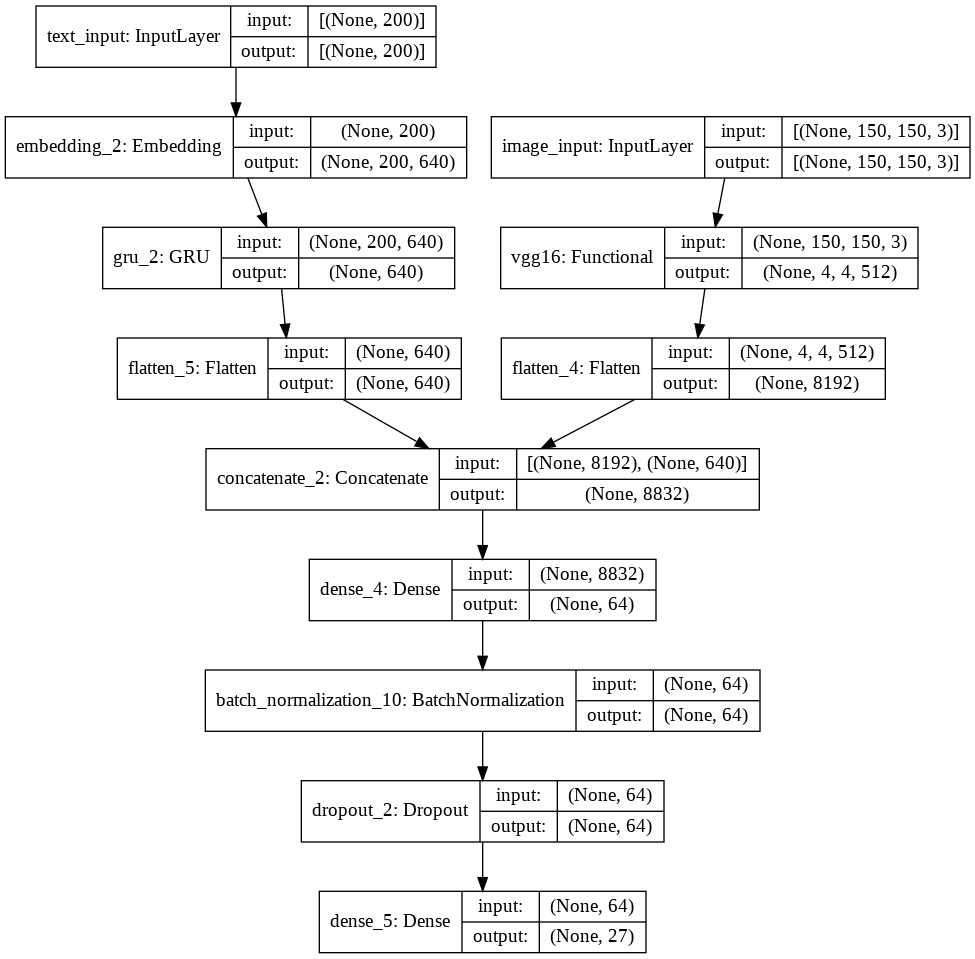

In [ ]:
#instanciate a model with two input tensors and a classifier composed of 2 dense layers
multimodal_model4 = tf.keras.Model([image_input,text_input],outputs)
# summarize layers
print(multimodal_model4.summary())
tf.keras.utils.plot_model(multimodal_model4, show_shapes=True)

In [ ]:
import time
#CategoricalCrossentropy : Computes the crossentropy loss between the labels and predictions
#CategoricalAccuracy :  Calculates how often predictions match one-hot labels.
multimodal_model4.compile(
    optimizer='adam', loss=['categorical_crossentropy'],
    metrics=['accuracy'])

#callback to stop training phase when val_loss is no more decreasing
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=4,
                                         mode='min',
                                         restore_best_weights=True)

# training of the fucntional model multimodal (Image + text)
import time
traingen = CustomDataGen(df_train,
                         X_col_img={'nom_img':'nom_img'},
                         X_col_txt={'designation_str_tokens':'designation_str_tokens'},
                         y_col={'class_onehot': 'class_onehot'},
                         batch_size=32, input_size=(150, 150, 3),input_text_size=200)

print(type(traingen))

valgen = CustomDataGen(df_test,
                       X_col_img={'nom_img':'nom_img'},
                       X_col_txt={'designation_str_tokens':'designation_str_tokens'},
                       y_col={'class_onehot': 'class_onehot'},
                       batch_size=32, input_size=(150, 150, 3),input_text_size=200)

start = time.time()
with tf.device(BESTDEV): # explicitly activates GPU if available
  history = multimodal_model4.fit(traingen,validation_data=valgen,epochs=10,callbacks=[early_stopping])
end = time.time()
elapsed = round((end - start)/60)

print(f'\ncell execution duration : {elapsed:.2f} mn')

#multimodal_model4.save('Rakuten_multimodal_best_model_bis.h5')

<class '__main__.CustomDataGen'>
Epoch 1/10
2109/2109 [==============================] - 514s 243ms/step - loss: 1.1802 - accuracy: 0.6641 - val_loss: 0.6143 - val_accuracy: 0.8163
Epoch 2/10
2109/2109 [==============================] - 512s 243ms/step - loss: 0.4723 - accuracy: 0.8600 - val_loss: 0.5490 - val_accuracy: 0.8409
Epoch 3/10
2109/2109 [==============================] - 509s 241ms/step - loss: 0.2573 - accuracy: 0.9214 - val_loss: 0.5931 - val_accuracy: 0.8412
Epoch 4/10
2109/2109 [==============================] - 512s 243ms/step - loss: 0.1488 - accuracy: 0.9534 - val_loss: 0.6982 - val_accuracy: 0.8359
Epoch 5/10
2109/2109 [==============================] - 512s 243ms/step - loss: 0.0999 - accuracy: 0.9687 - val_loss: 0.7660 - val_accuracy: 0.8350
Epoch 6/10
2109/2109 [==============================] - 512s 243ms/step - loss: 0.0753 - accuracy: 0.9766 - val_loss: 0.8934 - val_accuracy: 0.8277

cell execution duration : 51.00 mn


In [ ]:
multimodal_model4.save('/content/drive/MyDrive/Rakuten/Rakuten_multimodal_best_model_8409_pretrained_VGG16_embedding-GRU.h5')

# Use case : Image + text handling and  Xception model without its weigths

**Image chain : Xception model (all layers set trainable)**<br>
**text chain : embedding + GRU layers**<br>

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.xception import Xception

#when both Embedding and Xception need huge amount of memory 


max_features=49507

# Modèle Xception
base_model = Xception(weights='imagenet', include_top=False,input_shape=(150,150,3))
# Unfreeze all layers of the model
for layer in base_model.layers: 
    layer.trainable = True


image_input = tf.keras.Input(shape=(150,150,3),name="image_input")
x = base_model(image_input)
encoded_image = Flatten()(x)

text_input = tf.keras.Input(shape=(200),name="text_input")
embedded_text = Embedding(max_features+1,640)(text_input)
y = GRU(640)(embedded_text)
encoded_txt = Flatten()(y)

# Concatenate both encoded images and text and pass through the classification layer.
#Normalization is mandatory for Neural Network with numerous hidden layers
#but this design pattern is anyway useful to ease weights calculation during descent gradient backpropagation 

concatenated = tf.keras.layers.Concatenate()([encoded_image, encoded_txt])
classifier_lay1 = tf.keras.layers.Dense(256, activation="relu")(concatenated)
classifier_lay2 = tf.keras.layers.BatchNormalization()(classifier_lay1)
classifier_lay3 = tf.keras.layers.Dropout(0.2)(classifier_lay2)
outputs = tf.keras.layers.Dense(27, activation="softmax")(classifier_lay3)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 200)]        0                                            
__________________________________________________________________________________________________
image_input (InputLayer)        [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 640)     31685120    text_input[0][0]                 
__________________________________________________________________________________________________
xception (Functional)           (None, 5, 5, 2048)   20861480    image_input[0][0]                
______________________________________________________________________________________________

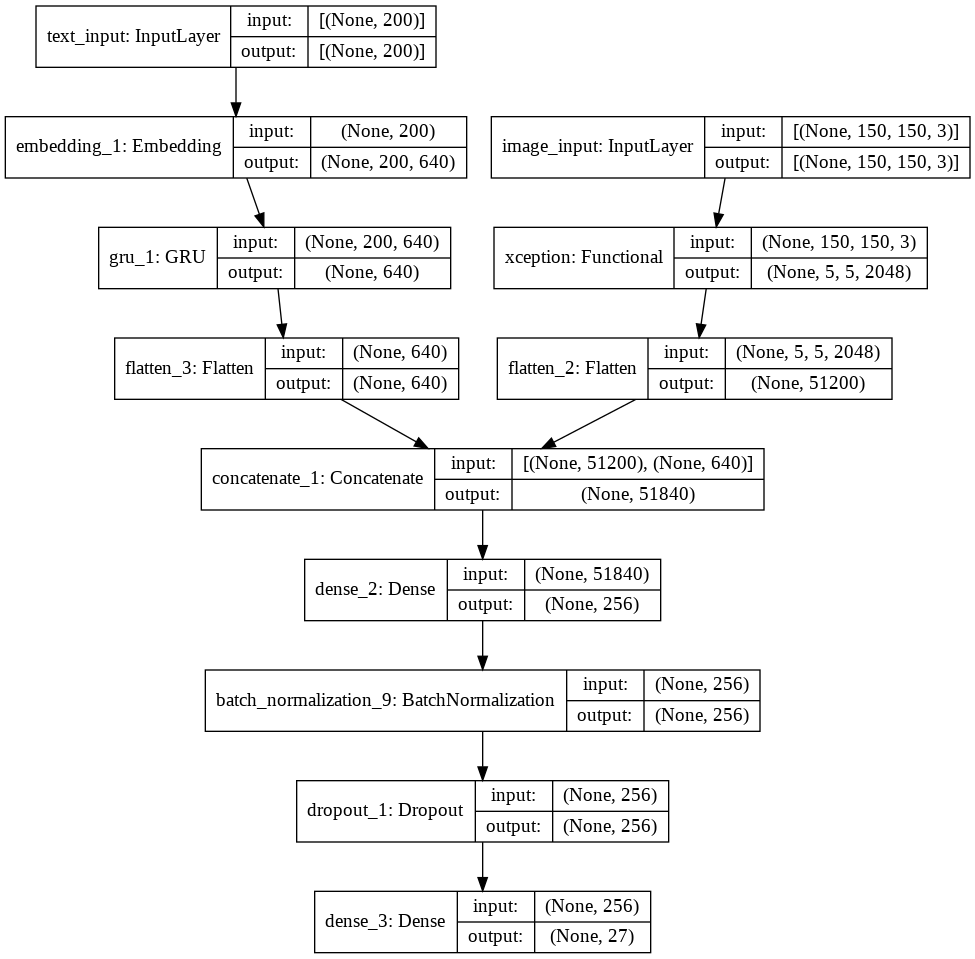

In [ ]:
#instanciate a model with two input tensors and a classifier composed of 2 dense layers
# conclusion : 
multimodal_model6 = tf.keras.Model([image_input,text_input],outputs)
# summarize layers
print(multimodal_model6.summary())
tf.keras.utils.plot_model(multimodal_model6, show_shapes=True)

In [ ]:
import time
#CategoricalCrossentropy : Computes the crossentropy loss between the labels and predictions
#CategoricalAccuracy :  Calculates how often predictions match one-hot labels.
multimodal_model6.compile(
    optimizer='adam', loss=['categorical_crossentropy'],
    metrics=['accuracy'])

#callback to stop training phase when val_loss is no more decreasing
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=4,
                                         mode='min',
                                         restore_best_weights=True)


# training of the fucntional model multimodal (Image + text)
import time
traingen = CustomDataGen(df_train,
                         X_col_img={'nom_img':'nom_img'},
                         X_col_txt={'designation_str_tokens':'designation_str_tokens'},
                         y_col={'class_onehot': 'class_onehot'},
                         batch_size=32, input_size=(150, 150, 3),input_text_size=200)

print(type(traingen))

valgen = CustomDataGen(df_test,
                       X_col_img={'nom_img':'nom_img'},
                       X_col_txt={'designation_str_tokens':'designation_str_tokens'},
                       y_col={'class_onehot': 'class_onehot'},
                       batch_size=32, input_size=(150, 150, 3),input_text_size=200)

start = time.time()
with tf.device(BESTDEV): # explicitly activates GPU if available
  history = multimodal_model6.fit(traingen,validation_data=valgen,epochs=15,callbacks=[early_stopping])
end = time.time()
elapsed = round((end - start)/60)

print(f'\ncell execution duration : {elapsed:.2f} mn')

<class '__main__.CustomDataGen'>
Epoch 1/15
2109/2109 [==============================] - 896s 413ms/step - loss: 1.4048 - accuracy: 0.5912 - val_loss: 0.8042 - val_accuracy: 0.7588
Epoch 2/15
2109/2109 [==============================] - 869s 412ms/step - loss: 0.5736 - accuracy: 0.8275 - val_loss: 0.6027 - val_accuracy: 0.8252
Epoch 3/15
2109/2109 [==============================] - 867s 411ms/step - loss: 0.3301 - accuracy: 0.8983 - val_loss: 0.5865 - val_accuracy: 0.8337
Epoch 4/15
2109/2109 [==============================] - 863s 409ms/step - loss: 0.2027 - accuracy: 0.9363 - val_loss: 0.6471 - val_accuracy: 0.8314
Epoch 5/15
2109/2109 [==============================] - 861s 408ms/step - loss: 0.1373 - accuracy: 0.9553 - val_loss: 0.7602 - val_accuracy: 0.8269
Epoch 6/15
2109/2109 [==============================] - 864s 410ms/step - loss: 0.0969 - accuracy: 0.9692 - val_loss: 0.8376 - val_accuracy: 0.8222
Epoch 7/15
2109/2109 [==============================] - 867s 411ms/step - loss:

In [ ]:
multimodal_model6.save('/content/drive/MyDrive/Rakuten/Rakuten_multimodal_Xception_embedding-GRU.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


in progress : 2000 samples over 16876 done 
in progress : 4000 samples over 16876 done 
in progress : 6000 samples over 16876 done 
in progress : 8000 samples over 16876 done 
in progress : 10000 samples over 16876 done 
in progress : 12000 samples over 16876 done 
in progress : 14000 samples over 16876 done 

cell execution duration : 18.00 mn
              precision    recall  f1-score   support

          10       0.54      0.78      0.64       631
          40       0.92      0.75      0.83       465
          50       0.75      0.83      0.79       335
          60       0.99      0.79      0.88       154
        1140       0.71      0.83      0.77       515
        1160       0.96      0.96      0.96       771
        1180       0.51      0.70      0.59       169
        1280       0.74      0.70      0.72       969
        1281       0.52      0.64      0.58       396
        1300       0.95      0.95      0.95       995
        1301       0.96      0.92      0.94       155
    

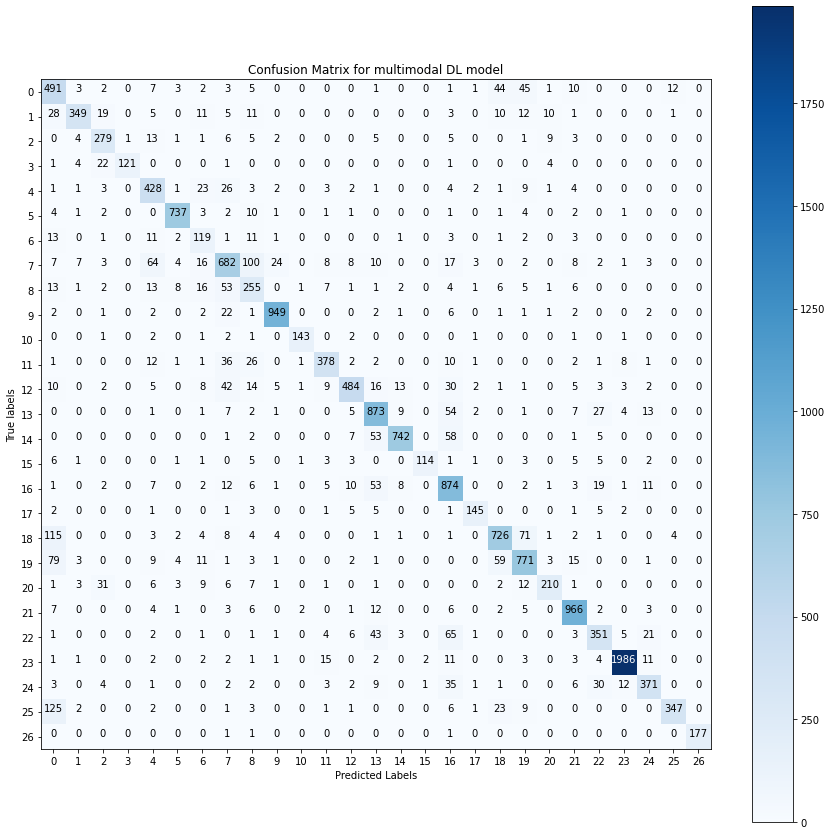

In [ ]:
from tensorflow.keras.models import load_model

def transform_image(path, target_size):
    """function that converts an image and put it into a tensor 4D"""
    image = tf.keras.preprocessing.image.load_img(path)
    image_arr = tf.keras.preprocessing.image.img_to_array(image)

    image_arr = tf.image.resize(image_arr,(target_size[0], target_size[1])).numpy()
    image_arr = np.expand_dims(image_arr,axis=0)# image 3D becoming a tensor 4D (one dimension added)
    
    return image_arr/255.

def transform_text(text_in,size):
    """function that converts an text and put it into a tensor 2D"""
    X_text_int = tokenizer.texts_to_sequences([text_in])
    #pad or truncate list of integers
    text = tf.keras.preprocessing.sequence.pad_sequences(X_text_int,maxlen=size,padding='post',truncating='post')
    #only return the list not a list of one list !!!!!!
    return text

multimodal_sav = load_model('/content/drive/MyDrive/Rakuten/Rakuten_multimodal_Xception_embedding-GRU.h5')

test_pred_class = []
y_test_class = []
target_size = (150,150,3)
text_size=200
num_classes = 27

start = time.time()
for i in range(len(df_test)):
    if ((i == 2000) | (i == 4000) | (i == 6000) | (i == 8000) | (i == 10000) | (i == 12000) | (i == 14000)):
        print("in progress : {0} samples over {1} done ".format(i,len(df_test)))
    img_tensor = transform_image(df_test['nom_img'].iloc[i], target_size)
    txt_tensor = transform_text(df_test['designation_str_tokens'].iloc[i], text_size)
    test_pred = multimodal_sav.predict([img_tensor,txt_tensor])
    test_pred_class_img = test_pred.argmax(axis = 1)
    test_pred_class.append(list_class[test_pred_class_img[0]])
    
    #y_test = tf.keras.utils.to_categorical(df_test['class_onehot'].iloc[i], num_classes=num_classes)
    #y_test_class_img = y_test.argmax()
    y_test_class.append(list_class[df_test['class_onehot'].iloc[i]])
    
end = time.time()
elapsed = round((end - start)/60)

print(f'\ncell execution duration : {elapsed:.2f} mn')
    

print(metrics.classification_report(y_test_class, test_pred_class))

import itertools # To create iterators

cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class)

classes = range(0,27)

plt.figure(figsize = (15,15))

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Confusion Matrix for multimodal DL model")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)


for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('True labels')
plt.xlabel('Predicted Labels')
plt.show()


# Use case : Image + text handling with classifier composed of 2 Dense layers

**image chain : pretrained Xception**<br>
**text chain : embedding + GRU layers**

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.xception import Xception

#when both Embedding and Xception need huge amount of memory 


max_features=49507

# Modèle Xception
base_model = Xception(weights='imagenet', include_top=False,input_shape=(150,150,3))
# Unfreeze all layers of the model
for layer in base_model.layers: 
    layer.trainable = False


image_input = tf.keras.Input(shape=(150,150,3),name="image_input")
x = base_model(image_input)
encoded_image = Flatten()(x)

text_input = tf.keras.Input(shape=(200),name="text_input")
embedded_text = Embedding(max_features+1,640)(text_input)
y = GRU(640)(embedded_text)
encoded_txt = Flatten()(y)

# Concatenate both encoded images and text and pass through the classification layer.
#Normalization is mandatory for Neural Network with numerous hidden layers
#but this design pattern is anyway useful to ease weights calculation during descent gradient backpropagation 

concatenated = tf.keras.layers.Concatenate()([encoded_image, encoded_txt])
classifier_lay1 = tf.keras.layers.Dense(256, activation="relu")(concatenated)
classifier_lay2 = tf.keras.layers.BatchNormalization()(classifier_lay1)
classifier_lay3 = tf.keras.layers.Dropout(0.2)(classifier_lay2)
outputs = tf.keras.layers.Dense(27, activation="softmax")(classifier_lay3)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 200)]        0                                            
__________________________________________________________________________________________________
image_input (InputLayer)        [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 640)     31685120    text_input[0][0]                 
__________________________________________________________________________________________________
xception (Functional)           (None, 5, 5, 2048)   20861480    image_input[0][0]                
______________________________________________________________________________________________

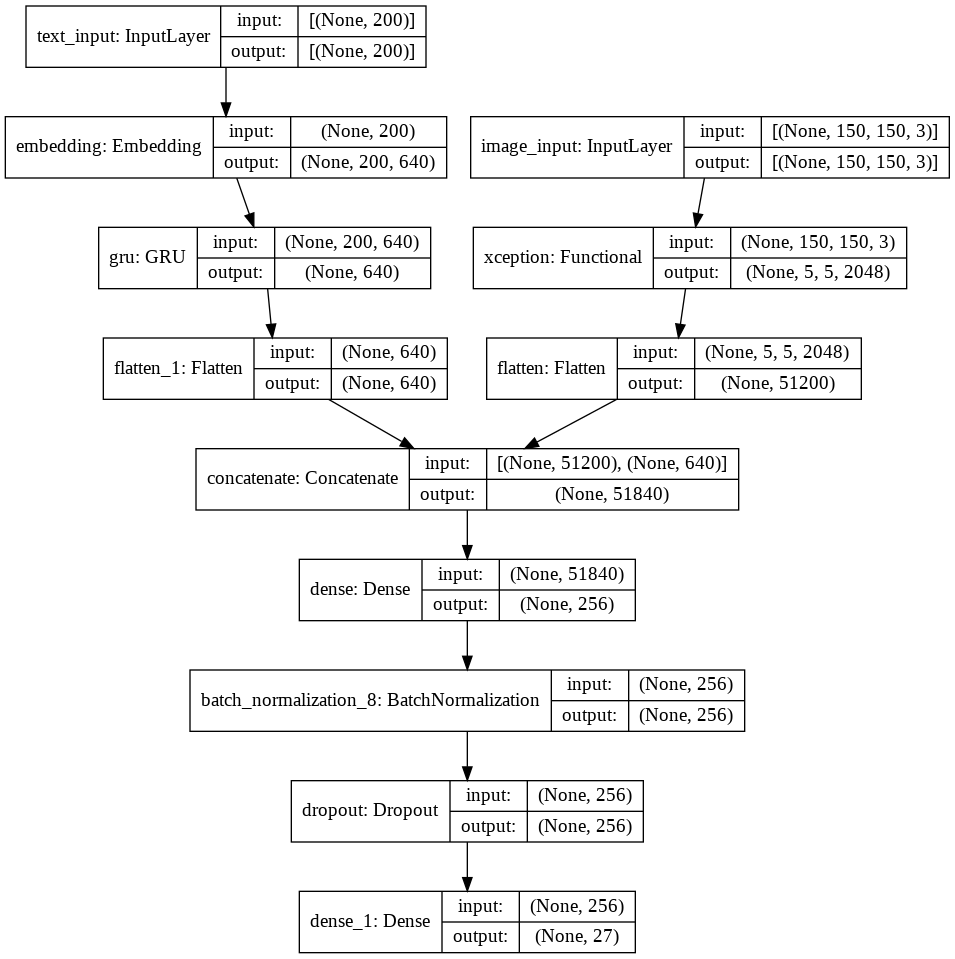

In [ ]:
#instanciate a model with two input tensors and a classifier composed of 2 dense layers
# conclusion : 
multimodal_model7 = tf.keras.Model([image_input,text_input],outputs)
# summarize layers
print(multimodal_model7.summary())
tf.keras.utils.plot_model(multimodal_model7, show_shapes=True)

In [ ]:
multimodal_model7.compile(
    optimizer='adam', loss=['categorical_crossentropy'],
    metrics=['accuracy'])

#callback to stop training phase when val_loss is no more decreasing
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=4,
                                         mode='min',
                                         restore_best_weights=True)


# training of the fucntional model multimodal (Image + text)
import time
traingen = CustomDataGen(df_train,
                         X_col_img={'nom_img':'nom_img'},
                         X_col_txt={'designation_str_tokens':'designation_str_tokens'},
                         y_col={'class_onehot': 'class_onehot'},
                         batch_size=32, input_size=(150, 150, 3),input_text_size=200)

print(type(traingen))

valgen = CustomDataGen(df_test,
                       X_col_img={'nom_img':'nom_img'},
                       X_col_txt={'designation_str_tokens':'designation_str_tokens'},
                       y_col={'class_onehot': 'class_onehot'},
                       batch_size=32, input_size=(150, 150, 3),input_text_size=200)

start = time.time()
with tf.device(BESTDEV): # explicitly activates GPU if available
  history = multimodal_model7.fit(traingen,validation_data=valgen,epochs=15,callbacks=[early_stopping])
end = time.time()
elapsed = round((end - start)/60)

print(f'\ncell execution duration : {elapsed:.2f} mn')

<class '__main__.CustomDataGen'>
Epoch 1/15
2109/2109 [==============================] - 550s 252ms/step - loss: 1.4834 - accuracy: 0.5656 - val_loss: 1.0180 - val_accuracy: 0.6893
Epoch 2/15
2109/2109 [==============================] - 522s 248ms/step - loss: 0.7689 - accuracy: 0.7637 - val_loss: 0.8031 - val_accuracy: 0.7630
Epoch 3/15
2109/2109 [==============================] - 518s 245ms/step - loss: 0.4798 - accuracy: 0.8481 - val_loss: 0.7798 - val_accuracy: 0.7895
Epoch 4/15
2109/2109 [==============================] - 520s 247ms/step - loss: 0.3111 - accuracy: 0.9019 - val_loss: 0.8149 - val_accuracy: 0.7982
Epoch 5/15
2109/2109 [==============================] - 521s 247ms/step - loss: 0.2106 - accuracy: 0.9324 - val_loss: 0.8613 - val_accuracy: 0.7979
Epoch 6/15
2109/2109 [==============================] - 521s 247ms/step - loss: 0.1516 - accuracy: 0.9511 - val_loss: 0.9668 - val_accuracy: 0.7956
Epoch 7/15
2109/2109 [==============================] - 521s 247ms/step - loss:

In [ ]:
# save not done as not the best model found
#multimodal_model7.save('/content/drive/MyDrive/Rakuten/Rakuten_multimodal_pretrained_Xception_embedding-GRU.h5')